In [2]:
# downloading and extracting dataset images
!unzip /content/drive/MyDrive/Applied_AI_project/dataset_1.zip

Archive:  /content/drive/MyDrive/Applied_AI_project/dataset_1.zip
replace dataset_1/bacterial spot/Bs1.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset_1/bacterial spot/Bs1.JPG  
  inflating: dataset_1/bacterial spot/Bs1_change_180.jpg  
  inflating: dataset_1/bacterial spot/Bs1_change_90.jpg  
  inflating: dataset_1/bacterial spot/Bs1_hight.jpg  
  inflating: dataset_1/bacterial spot/Bs1_lower.jpg  
  inflating: dataset_1/bacterial spot/Bs1_mirror.jpg  
  inflating: dataset_1/bacterial spot/Bs1_mirror_vertical.jpg  
  inflating: dataset_1/bacterial spot/Bs10.JPG  
  inflating: dataset_1/bacterial spot/Bs10_change_180.jpg  
  inflating: dataset_1/bacterial spot/Bs10_change_270.jpg  
  inflating: dataset_1/bacterial spot/Bs10_change_90.jpg  
  inflating: dataset_1/bacterial spot/Bs10_hight.jpg  
  inflating: dataset_1/bacterial spot/Bs10_lower.jpg  
  inflating: dataset_1/bacterial spot/Bs10_mirror.jpg  
  inflating: dataset_1/bacterial spot/Bs10_mirror_vertical.jpg  
 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_TYPE = 'dataset_1'
ARCHITECTURE = 'vgg'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# splitting the dataset into specific folders for train, validate and test
!pip install split-folders

import splitfolders

source_folder = f'/content/{DATASET_TYPE}'
target_folder = f'/content/{DATASET_TYPE}_splitted'

train_ratio = .7
val_ratio = .15
test_ratio = .15

splitfolders.ratio(source_folder, output=target_folder, seed=1337, ratio=(train_ratio, val_ratio, test_ratio), group_prefix=None, move=False)

Copying files: 2009 files [00:00, 4921.70 files/s]


In [4]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

In [5]:
# applying data prepocessing and loading dataset
train_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(f"/content/{DATASET_TYPE}_splitted/train", transform=train_dataset_tranform)
train_length = len(train_dataset)

validate_dataset = ImageFolder(f"/content/{DATASET_TYPE}_splitted/val", transform=test_dataset_tranform)
validate_length = len(validate_dataset)

test_dataset = ImageFolder(f"/content/{DATASET_TYPE}_splitted/test", transform=test_dataset_tranform)
test_lengtg = len(test_dataset)

dataset_classes = train_dataset.classes
print(dataset_classes)

['bacterial spot', 'healthy', 'late blight']


In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

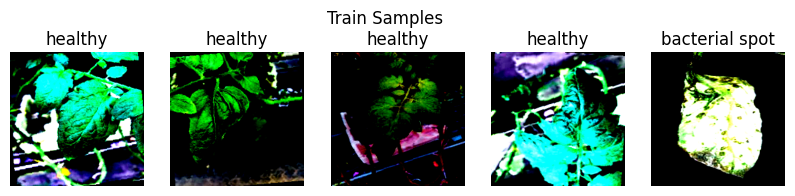

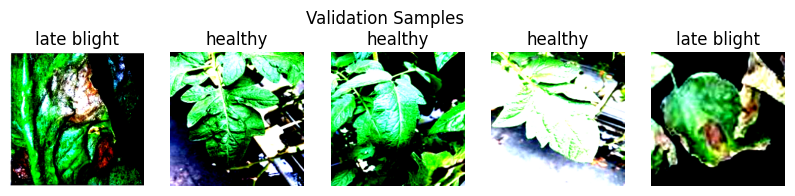

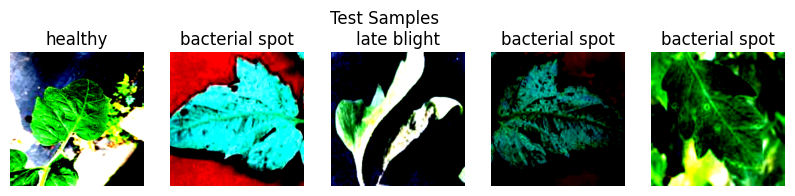

In [7]:
def show_images(loader, title):
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    images = images.numpy()
    labels = labels.numpy()

    # Plot the images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'{dataset_classes[labels[i]]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample images from train loader
show_images(train_loader, 'Train Samples')

# Display sample images from validation loader
show_images(validate_loader, 'Validation Samples')

# Display sample images from test loader
show_images(test_loader, 'Test Samples')

In [10]:
# setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
# modifying architecture output classes
class VGG16(nn.Module):
  def __init__(self, num_of_classes):
    super(VGG16, self).__init__()
    self.model = vgg16(weights=None)
    features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(features, num_of_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [12]:
# defining model, optimizer, architecture
learning_rate = 0.001
epochs = 15

model = VGG16(num_of_classes=len(dataset_classes))
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()

print(model)

VGG16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

epoch number ---> 1 
training loss: 2.0638  training accuracy: 34.83 %
validation loss: 1.0966  validation accuracy: 35.67 %
best loss obtained: 1.0966
--model saved--
epoch number ---> 2 
training loss: 1.0838  training accuracy: 38.39 %
validation loss: 1.0809  validation accuracy: 35.33 %
best loss obtained: 1.0809
--model saved--
epoch number ---> 3 
training loss: 1.0808  training accuracy: 40.38 %
validation loss: 1.0475  validation accuracy: 37.67 %
best loss obtained: 1.0475
--model saved--
epoch number ---> 4 
training loss: 0.9993  training accuracy: 48.08 %
validation loss: 0.9356  validation accuracy: 50.67 %
best loss obtained: 0.9356
--model saved--
epoch number ---> 5 
training loss: 1.0823  training accuracy: 42.52 %
validation loss: 0.8670  validation accuracy: 58.00 %
best loss obtained: 0.8670
--model saved--
epoch number ---> 6 
training loss: 0.8906  training accuracy: 54.34 %
validation loss: 0.7511  validation accuracy: 62.67 %
best loss obtained: 0.7511
--model 

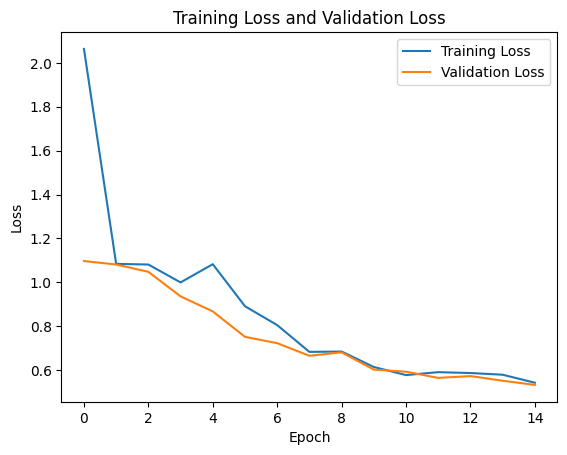

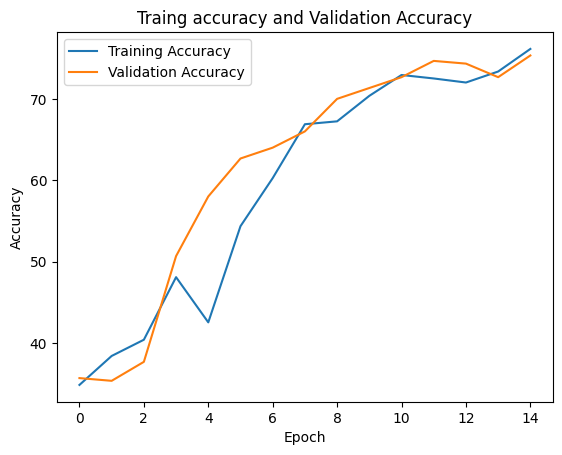

In [13]:
train_losses = []
train_accuracies = []
validate_losses = []
validate_accuracies = []
best_validate_loss = float('inf')
loss_wait_threshold = 5;
wait_counter = 0;

for epoch in range(epochs):

  print(f"epoch number ---> {epoch + 1} ")

  model.train()
  train_batch_loss = 0.0
  train_correct_predictions = 0
  train_samples = 0
  for xtrain, ytrain in train_loader:

    optimizer.zero_grad()

    xtrain = xtrain.to(device)
    ytrain = ytrain.to(device)
    train_prob = model(xtrain)

    # calculating batch accuracy
    _, train_prediction = torch.max(train_prob, 1)
    train_samples += ytrain.size(0)
    train_correct_predictions += (train_prediction == ytrain).sum().item()

    loss = loss_function(train_prob, ytrain)
    loss.backward()
    optimizer.step()

    # calculating batch loss
    train_batch_loss += loss.item()

  # calculating train loss for epoch
  train_loss = train_batch_loss / len(train_loader)
  train_losses.append(train_loss)

  # calculating train accuracy for epoch
  train_accuracy = 100 * (train_correct_predictions / train_samples)
  train_accuracies.append(train_accuracy)
  print("training loss: {:.4f}  training accuracy: {:.2f} %".format(train_loss, train_accuracy))

  validate_batch_loss = 0.0
  validate_correct_predictions = 0
  validate_samples = 0
  model.eval()
  with torch.no_grad():
    for xvalidate, yvalidate in validate_loader:

      optimizer.zero_grad()

      xvalidate = xvalidate.to(device)
      yvalidate = yvalidate.to(device)
      validate_prob = model(xvalidate)

      #calculating batch accuracy
      _, validate_prediction = torch.max(validate_prob, 1)
      validate_samples += yvalidate.size(0)
      validate_correct_predictions += (validate_prediction == yvalidate).sum().item()

      loss = loss_function(validate_prob, yvalidate)

      #calculating batch loss
      validate_batch_loss += loss.item()

  # calculating validate loss for epoch
  validate_loss = validate_batch_loss / len(validate_loader)
  validate_losses.append(validate_loss)

  # calculating validate accuracy for epoch
  validate_accuracy = 100 * (validate_correct_predictions / validate_samples)
  validate_accuracies.append(validate_accuracy)
  print("validation loss: {:.4f}  validation accuracy: {:.2f} %".format(validate_loss, validate_accuracy))

  if validate_loss < best_validate_loss:
    best_validate_loss = validate_loss
    print("best loss obtained: {:.4f}".format(best_validate_loss))
    torch.save(model.state_dict(), 'best_model_details.pth')
    print(f"--model saved--")
    wait_counter = 0
  else:
    wait_counter += 1
    if wait_counter >= loss_wait_threshold:
      print(f"loss variation exceeded threshold")
      break;

print(f"training and validation for {epochs} epochs completed")
print(f"train losses: {train_losses}")
print(f"train accuracies: {train_accuracies}")
print(f"validation losses: {validate_losses}")
print(f"validation accuracies: {validate_accuracies}")

# saving metrics to a file
np.savez(f'/content/{ARCHITECTURE}_{DATASET_TYPE}_metrics.npz',
         train_losses=train_losses,
         train_accuracies=train_accuracies,
         validate_losses=validate_losses,
         validate_accuracies=validate_accuracies)

plt.plot(train_losses, label='Training Loss')
plt.plot(validate_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validate_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Traing accuracy and Validation Accuracy')
plt.legend()
plt.show()

In [14]:
#loading the saved model

best_model_values = torch.load('/content/best_model_details.pth')
model.load_state_dict(best_model_values)

total_samples = []
total_predictions = []

# testing the model againt test dataset
test_batch_loss = 0.0
test_correct_predictions = 0
test_samples = 0
model.eval()
with torch.no_grad():
  for xtest, ytest in test_loader:
    optimizer.zero_grad()

    xtest = xtest.to(device)
    ytest = ytest.to(device)
    test_prob = model(xtest)

    #calculating batch accuracy
    _, test_prediction = torch.max(test_prob, 1)

    total_samples.extend(ytest.cpu().numpy())
    total_predictions.extend(test_prediction.cpu().numpy())

    test_samples += ytest.size(0)
    test_correct_predictions += (test_prediction == ytest).sum().item()

    loss = loss_function(test_prob, ytest)

    #calculating batch loss
    test_batch_loss += loss.item()

  # calculating validate loss for epoch
  test_loss = test_batch_loss / len(test_loader)

  # calculating validate accuracy for epoch
  test_accuracy = 100 * (test_correct_predictions / test_samples)
  print("test loss: {:.4f}  test accuracy: {:.2f} %".format(test_loss, test_accuracy))

  # saving test metric to file
  np.savez(f'/content/{ARCHITECTURE}_{DATASET_TYPE}_testmetrics.npz',
         total_samples=total_samples,
         total_predictions=total_predictions,
         test_loss=[test_loss],
         test_accuracy=[test_accuracy])

test loss: 0.5239  test accuracy: 77.70 %


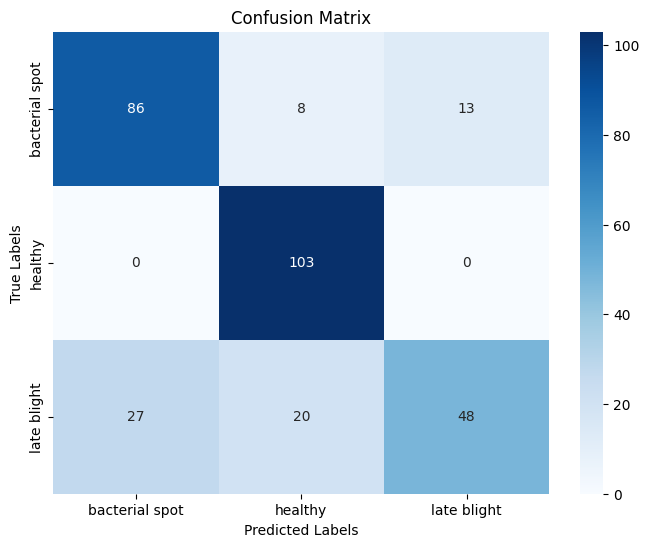

In [15]:
# displaying confusion matrix
confusion_matrix = confusion_matrix(total_samples, total_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            cmap='Blues',
            fmt='g',
            xticklabels=dataset_classes,
            yticklabels=dataset_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Generate the classification report
print(classification_report(total_samples, total_predictions, target_names=dataset_classes))

                precision    recall  f1-score   support

bacterial spot       0.76      0.80      0.78       107
       healthy       0.79      1.00      0.88       103
   late blight       0.79      0.51      0.62        95

      accuracy                           0.78       305
     macro avg       0.78      0.77      0.76       305
  weighted avg       0.78      0.78      0.76       305



In [17]:
# calculating precision, recall, f1-score and accuracy

accuracy = accuracy_score(total_samples, total_predictions)
precision = precision_score(total_samples, total_predictions, average = 'weighted')
recall = recall_score(total_samples, total_predictions, average = 'weighted')
f1score = (2 * precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")

Accuracy: 0.7770491803278688
Precision: 0.7776146213234993
Recall: 0.7770491803278688
F1-score: 0.7773317979984622
